# Introduction

This notebook explains how to clean cosmic void catalogues to extract cosmological constraints from void statistics. 

The only required inputs are the positions of the void centres and of the tracers used to detect the voids (and possibly their masses). 

With this notebook you will remove spurious voids, rescale their radii to a specific density threshold, and reject voids in case of overlaps. Then you will measure the void size function and compare it to theoretical predictions. The latter are computed with a re-parametrisation of the volume-conserving model (Vdn), that takes into account the effect of the tracer bias (see Ronconi et al. 2019, Contarini et al. 2019).

# Set the inputs

To ensure compatibility in Python versions 2.x and 3.x

In [1]:
from __future__ import print_function

Import the CBL functions and system modules:

In [2]:
import CosmoBolognaLib as cbl                                 
from CosmoBolognaLib import ErrorCBL

import time
import sys
import os

To show the standard output stream of the CBL functions (that are implemented in C++ and converted to python via SWIG) on notebook cells (instead of on terminal) the package wurlitzer has to be used (see https://github.com/minrk/wurlitzer)

In [3]:
%load_ext wurlitzer

The paramters are read from the parameter file:

In [4]:
filename = "../input/parameter_file.ini"
print ("Loading parameters from", filename)
param = cbl.ReadParameters(filename)

Loading parameters from ../input/parameter_file.ini


The coordinate type is selected (warning: observed coordinates are still not implemented!):

In [5]:
if param.findBool('comovingCoordinates') :
  coordinates = cbl.CoordinateType__comoving_
else :
  coordinates = cbl.CoordinateType__observed_

# Load the input void catalogue
Only the void centre coordinates have to be provided to construct the input void catalogue, while all the other necessary attributes will be computed automatically

In [6]:
cast = []
clmn = []
attrNames = ['X_coord', 'Y_coord', 'Z_coord', 'Radius', 'centralDensity', 'densityContrast']
attrAv = [cbl.Var__X_, cbl.Var__Y_, cbl.Var__Z_, cbl.Var__Radius_, cbl.Var__CentralDensity_,\
          cbl.Var__DensityContrast_]
for ii in range(len(attrNames)) :
  if param.findBool(attrNames[ii]) :
    cast.append(attrAv[ii])
    clmn.append(param.findInt(attrNames[ii]+'_clmn'))
clmn, cast = (list(x) for x in zip(*sorted(zip(clmn, cast))))

attr = cbl.VarCast(cast)

A new void catalogue is created, reading the input file and sorting the attributes according the selected order:

In [7]:
vdcat = cbl.Catalogue(cbl.ObjectType__Void_,
                       coordinates,
                       attr,
                       clmn,
                       [param.findString('inputVoidCatalogue')],
                       param.findInt('vd_comments'))

CBL > I'm reading the catalogue: ../input/void_catalogue.txt


The main properties of the catalogue (volume, density and mean interparticle separation of the sample) are computed using the lenght of the catalogue side. For the current implementation, the catalogue geometry has to be a box. If the boxside is not provided, it will be computed using the maximum separaration between the tracers on the x-axis.

In [8]:
if (param.findDouble('boxside') < 0.) :
  boxside = abs(vdcat.Max(cbl.Var__X_) - vdcat.Min(cbl.Var__X_))
else :
  boxside = param.findDouble('boxside')
vdcat.compute_catalogueProperties(param.findDouble('boxside'))

CBL > Sample volume = 1.25e+08 (Mpc/h)^3
CBL > Sample density = 9.904e-06 (Mpc/h)^-3
CBL > Sample mps = 46.5654 Mpc/h


# Load the input tracer catalogue

The tracer catalogue can be either a Gadget-2.0 or an ASCII file. Using the parameters 'fact' and 'nSub', it is possible to convert the distance units (e.g. fact = 0.001 for converting kpc/h to Mpc/h) and to sub-sample the objects of the catalogue, respectively. <br> Only for ASCII catalogues, a mass factor and/or a mass cut-off can be applied to the tracer catalogue (obviously only if the tracer mass is provided). The first one can be activated with the parameter 'Munit', that represents the mass units in units of solar masses. The cut-off is applied by selecting a value larger than $0$ for the minimum mass of the catalogue, given by the 'Mmin' parameter.
In the end, the main properties of the catalogue are computed using (once again) the lenght of the boxside.

In [9]:
if param.findBool('Gadget') :
  if not param.findBool('comovingCoordinates') :
    ErrorCBL('Observed coordinates not available for Gadget snapshot.')
  else :
    trcat = cbl.Catalogue (cbl.ObjectType__Halo_,
                           param.findString('inputTracersFile'),
                           param.findBool('swapEndianism'),
                           param.findDouble('fact'),
                           True,
                           param.findDouble('nSub'))
else :
  if param.findBool('comovingCoordinates') :
    tr_cast = []
    tr_clmn = []
    trAttrNames = ['X_coord_tr', 'Y_coord_tr', 'Z_coord_tr', 'Mass']
    trAttrAv = [cbl.Var__X_, cbl.Var__Y_, cbl.Var__Z_, cbl.Var__Mass_]
    for ii in range(len(trAttrNames)) :
      if param.findBool(trAttrNames[ii]) :
        tr_cast.append(trAttrAv[ii])
        tr_clmn.append(param.findInt(trAttrNames[ii]+'_clmn'))        
    tr_clmn, tr_cast = (list(x) for x in zip(*sorted(zip(tr_clmn, tr_cast))))  # orders clmn and cast according to column order 
    tr_attr = cbl.VarCast(tr_cast)
    
    temp = cbl.Catalogue (cbl.ObjectType__Halo_,
                          coordinates,
                          tr_attr,
                          tr_clmn,
                          [param.findString('inputTracersFile')],
                          param.findInt('tr_comments'),
                          param.findDouble('nSub'),
                          param.findDouble('fact'))

    if not param.findBool('Mass') :
      
      trcat = temp
      temp = None
      print ("Finished reading input tracers catalogue.")
      
    else :
      
      print ("Finished reading input tracers catalogue, now applying mass scale factor and/or cut-off ... ")

      # scale factor
      if (param.findDouble('Munit') > 0.) :
        for ii in range(temp.nObjects()) :
          mass = temp.mass(ii)*param.findDouble('Munit')
          temp.set_var(ii, cbl.Var__Mass_, mass)

      # mass cut-off
      if (param.findDouble('Mmin') > 0.) :
        trcat = cbl.Catalogue ()
        trcat = temp.sub_catalogue(cbl.Var__Mass_, param.findDouble('Mmin'), temp.Max(cbl.Var__Mass_), False)
      else :
        trcat = temp
        temp = None

      print ("\t ... done!")

  # observed coordinates
  else :
    print ("Observed coordinates not supported yet...")
    exit(1)

trcat.compute_catalogueProperties(param.findDouble('boxside'))

Finished reading input tracers catalogue.
CBL > I'm reading the catalogue: ../input/halo_catalogue.txt
CBL > Sample volume = 1.25e+08 (Mpc/h)^3
CBL > Sample density = 0.0015764 (Mpc/h)^-3
CBL > Sample mps = 8.59233 Mpc/h


If the void radii are not read from the input void catalogue, they are temporarily set to the maximum value of the range of the accepted radii:

In [10]:
if not param.findBool('Radius') :
  delta_r = param.findVectorDouble('delta_r')
  radii = [delta_r[1] for ii in range(vdcat.nObjects())]
  vdcat.set_var(cbl.Var__Radius_, radii)

A 3-dimensional chain-mesh for the input tracer catalogue is generated. The cell size of the chain-mesh is equal to 2 times the value of the mean interparticle separation of the tracer catalogue. The maximum radius of the chain-mesh is given by the maximum value of the radius of the voids in the catalogue.

In [11]:
ChM = cbl.ChainMesh3D (2.*trcat.mps(),
                       trcat.var(cbl.Var__X_),
                       trcat.var(cbl.Var__Y_),
                       trcat.var(cbl.Var__Z_),
                       vdcat.Max(cbl.Var__Radius_))

The central density and the density contrast are computed if they are not read from the input void catalogue. <br> The central density (in units of the average density) is computed as the density of a sphere centred in the void centre and with radius $R = ratio \cdot r_{eff}$, where $r_{eff}$ is the void effective radius and $ratio$ is a parameter $<1$ selected by the user. The density contrast is the ratio between the central density and the density within the sphere centred in the void centre and with radius $R = r_{eff}$. <br> With the compute_densityContrast function, the effect of cloud-in-void is taken into account and the voids with central density larger than the density at $r_{eff}$ are rejected.

In [12]:
if not param.findBool('centralDensity') : 
  vdcat.compute_centralDensity(trcat,
                               ChM,
                               trcat.numdensity(),
                               param.findDouble('ratio'))

if not param.findBool('densityContrast') :
  vdcat.compute_densityContrast(trcat,
                                ChM,
                                param.findDouble('ratio'))

CBL > I removed 0 voids in calculating the central density!
CBL > Cloud-in-void: 84
CBL > I removed 84 voids in calculating the density contrast!


The criterion for the overlap-check is read from the parameter file. In case of overlap: <br>
1) if ol_crit = false $\rightarrow$ the void with the higher central density is rejected, <br>
2) if ol_crit = true $\rightarrow$ the void with the lower density constrast is rejected.

In [13]:
ol_crit = cbl.Var__DensityContrast_ if param.findInt('ol_crit') == 1 else cbl.Var__CentralDensity_

The threshold is the value of the spherically-averaged density contrast ($\rho_m/\,\overline{\rho}+1$) that each void will contain after the rescaling procedure. In this example, the threshold is not rescaled for different redshifts. This choise is not unique: the prescription is effective as long as the same density contrast is mantained for both the cleaning procedure and the theoretical void size function model.

In [14]:
threshold = param.findDouble('deltav_NL')+1.

# Costruct the cleaned catalogue
To build the final cleaned void catalogue, you can select different procedures to perform using the following parameters: <br>
 - clean1 = true $\rightarrow$ erase voids with underdensities higher than a given threshold<br>
 - clean2 = true $\rightarrow$ erase voids with effective radii outside a given range  <br>
 - clean3 = true $\rightarrow$ erase voids with density contrast lower than a given value, specified by the 'relevance' parameter <br>
 - delta_r $\rightarrow$ range of acceptable radii, voids with radii outside this range are erased <br>
 - rescale = true $\rightarrow$ the rescaling procedure will be performed: firstly the algorithm checks if within an initial radius the enclosed density is higher or lower than the selected density threshold; then it shrinks or expands the initial radius to match the required density threshold <br>
 - overlap = true $\rightarrow$  overlapping voids are erased from the catalogue: when two voids do overlap one of them is erased according to the chosen overlap criterion.

In [15]:
print ('\n')
tw0 = time.time()
tc0 = time.clock()
vdcat_cleaned = cbl.Catalogue (vdcat,
                               [param.findBool('clean1'),
                                param.findBool('clean2'),
                                param.findBool('clean3')],
                               param.findVectorDouble('delta_r'),
                               threshold,
                               param.findDouble('relevance'),
                               param.findBool('rescale'),
                               trcat,
                               ChM,
                               param.findDouble('ratio'),
                               param.findBool('overlap'),
                               ol_crit)


print ('Cleaning the catalogue took: ', time.clock()-tc0, ' sec')
print ('Wall time: ', time.time()-tw0, ' sec')



Cleaning the catalogue took:  9.791638  sec
Wall time:  9.79207611084  sec
CBL > Voids in the catalogue = 1154
CBL > Input void catalogue cleaning procedure started ...
CBL > ############ Removed Voids ###########
	 r_min - r_max criterion : 203
	 central density too high: 0
	 statistically irrelevant: 0
	 total removed: 203
CBL > Voids in the Catalogue: 951
CBL > Time spent by the cleaning procedure: 0.000702 seconds 

CBL > Rescaling radii ... 
CBL > Sample volume = 1.24994e+08 (Mpc/h)^3
CBL > Sample density = 0.00157648 (Mpc/h)^-3
CBL > Sample mps = 8.5922 Mpc/h
CBL > Empty voids removed: 0
CBL > Bad rescaled voids removed: 95

CBL > Removed voids out of range [17.00,150.00] : 502
CBL > I removed 0 voids in calculating the central density!
CBL > Cloud-in-void: 7
CBL > I removed 7 voids in calculating the density contrast!

CBL > Voids in the Catalogue: 347
CBL > Time spent by the rescaling procedure: 9.73139 seconds 

CBL > Checking for overlapping voids ...
CBL > I'm sorting the 

In the end, the cleaned catalogue is stored in an ASCII file (if the output directory does not exist, it will be created).

In [16]:
clmnsToPrint = cbl.VarCast(attrAv)

if not os.path.exists(param.findString('outputDir')):
    os.makedirs(param.findString('outputDir'))
    
print ('\n')

vdcat_cleaned.write_data(param.findString('outputDir')+param.findString('VoidCatalogueFile'),
                         clmnsToPrint)



CBL > I'm writing the file: ../output/cleaned_void_catalogue.out...
CBL > I wrote the file: ../output/cleaned_void_catalogue.out


# Compute the void size function
Once the cleaned void catalogue is built, the size function can be computed in order to compare the data to the theoretical predictions given by the Vdn model.

First, you need to import the required CBL functions and the matplotlib packages.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from matplotlib.pyplot import figure
%matplotlib inline

Set the CosmoBolognaLib and the current directories.

In [18]:
cbl.SetDirs(os.getcwd()+"/../../../", os.getcwd()+"/")

The cleaned void catalogue is loaded and the peripheral voids (close to the boundaries of the simulation box) are rejected, as their radii are not accurately rescaled by our cleaning algorithm, (periodic boundary conditions have not been implemented yet).

In [19]:
cast = []
clmn = []
attrNames = ['X_coord', 'Y_coord', 'Z_coord', 'Radius', 'centralDensity', 'densityContrast']
attrAv = [cbl.Var__X_, cbl.Var__Y_, cbl.Var__Z_, cbl.Var__Radius_, cbl.Var__CentralDensity_, cbl.Var__DensityContrast_]
for ii in range(len(attrNames)) :
  if param.findBool(attrNames[ii]) :
    cast.append(attrAv[ii])
    clmn.append(param.findInt(attrNames[ii]+'_clmn'))
clmn, cast = (list(x) for x in zip(*sorted(zip(clmn, cast))))  # orders clmn and cast according to column order 

attr = cbl.VarCast(cast)

inputVoidCatalogue = param.findString('outputDir')+param.findString('VoidCatalogueFile')

print (" Input void catalogue: ", inputVoidCatalogue)

vdcat = cbl.Catalogue (cbl.ObjectType__Void_,
                       coordinates,
                       attr,
                       clmn,
                       [inputVoidCatalogue],
                       param.findInt('vd_comments'))

cut = param.findDouble('cut')
vdcat = vdcat.sub_catalogue(cbl.Var__X_, vdcat.Min(cbl.Var__X_)+cut, vdcat.Max(cbl.Var__X_)-cut)
vdcat = vdcat.sub_catalogue(cbl.Var__Y_, vdcat.Min(cbl.Var__Y_)+cut, vdcat.Max(cbl.Var__Y_)-cut)
vdcat = vdcat.sub_catalogue(cbl.Var__Z_, vdcat.Min(cbl.Var__Z_)+cut, vdcat.Max(cbl.Var__Z_)-cut)

if (param.findDouble('boxside') < 0.) :
  boxside = abs(vdcat.Max(cbl.Var__X_) - vdcat.Min(cbl.Var__X_))
else :
  boxside = param.findDouble('boxside')-cut*2.
vdcat.compute_catalogueProperties(boxside)

 Input void catalogue:  ../output/cleaned_void_catalogue.out
CBL > I'm reading the catalogue: ../output/cleaned_void_catalogue.out
CBL > Sample volume = 9.7336e+07 (Mpc/h)^3
CBL > Sample density = 2.1472e-06 (Mpc/h)^-3
CBL > Sample mps = 77.5132 Mpc/h


According to its definition, the void size funciton can be computed as the comoving number density of voids in logarithmic bins of effective radii, divided by the logarithmic extent of the bins. Here the void abundance is measured with this prescription and saved as a text file. 

In [20]:
NC = cbl.NumberCounts1D_Size(vdcat, param.findInt("nbin"), param.findDouble("rmin"), param.findDouble("rmax"),
                             param.findDouble("shift"), cbl.HistogramType__dn_dlnV_,vdcat.volume())
NC.measure(cbl.ErrorType__Poisson_)
NC.write(param.findString("outputDir"), "Void_size_distr_z%4.2f"%(param.findDouble("redshift"))+".out")

rrp, ptp, erp = NC.dataset().xx(), NC.dataset().data(), NC.dataset().error()



CBL > I wrote the file: ../output/Void_size_distr_z0.00.out


A cosmological model is defined, using the cosmological parameters provided in the parameter file.

In [21]:
cosm = cbl.Cosmology(param.findDouble('OmM'),
                     param.findDouble('Omb'),
                     param.findDouble('Omn'),
                     param.findDouble('massless'),
                     param.findInt('massive'),
                     param.findDouble('OmL'),
                     param.findDouble('Omr'),
                     param.findDouble('hh'),
                     param.findDouble('As'),
                     param.findDouble('pivot'),
                     param.findDouble('ns'),
                     param.findDouble('w0'),
                     param.findDouble('wa'),
                     param.findDouble('fNL'),
                     param.findInt('type_NG'),
                     param.findDouble('tau'),
                     param.findString('model'),
                     param.findBool('unit'))

cosm.set_sigma8(param.findDouble('sigma8'))

The redshift of the catalogue is read from the parameter file.

In [22]:
zz = param.findDouble('redshift')
print (" Redshift =", zz)

 Redshift = 0.0


The effective bias of the mass tracer catalogue has been computed previously by the modelling of large-scale two-point correlation function.

In [23]:
b_eff = param.findDouble('b_eff')
print (" Effective bias =", b_eff)

 Effective bias = 1.122


The effective bias has to be converted to recover the one that characterises the relation between the tracer and the dark matter distribution inside cosmic voids. To do that, a pre-calibrated linear relation is used (see Contarini et al. 2019).

In [24]:
slope = param.findDouble('slope')
offset = param.findDouble('offset')

Non-linear underdensity threshold used to compute the theoretical model.

In [25]:
del_v = param.findDouble('deltav_NL')
print (" Non-linear underdensity threshold =", del_v)

 Non-linear underdensity threshold = -0.7


The theoretical void size function is computed at different radii and is rescaled to take into account the effect of the tracer bias.

In [26]:
rrt = np.linspace(param.findDouble('xmin'), param.findDouble('xmax'), param.findInt('ngrid'))

sff = []
for jj in range(len(rrt)):
    sff.append(cosm.size_function(rrt[jj], zz, "Vdn", b_eff, slope, offset, del_v))

CBL > ---> ./camb /home/sofia/ClusteringGroup/CosmoBolognaLib_git/External/CAMB/params_test.ini

Om_b h^2             =  0.022289
Om_c h^2             =  0.111691
Om_nu h^2            =  0.000000
Om_Lambda            =  0.728900
Om_K                 =  0.000000
Om_m (1-Om_K-Om_L)   =  0.271100
100 theta (CosmoMC)  =  1.039436
Reion opt depth      =  0.0000
Age of universe/GYr  =  13.785
zstar                =  1089.07
r_s(zstar)/Mpc       =  146.75
100*theta            =  1.039751
zdrag                =  1058.94
r_s(zdrag)/Mpc       =  149.49
k_D(zstar) Mpc       =  0.1385
100*theta_D          =  0.160681
z_EQ (if v_nu=1)     =  3204.00
100*theta_EQ         =  0.849168
tau_recomb/Mpc       =  285.18  tau_now/Mpc =  14398.9
 at z =    0.00000000      sigma8 (all matter)=  0.809011221    


The results are plotted to compare the measured void abundances with the theoretical predictions.

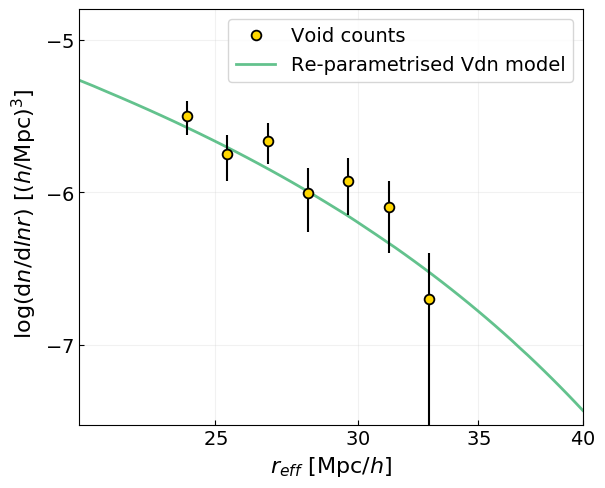

In [27]:
if (param.findBool("plot")):
    
  figure(num=None, figsize=(6.5, 5.5), dpi=100, facecolor='w', edgecolor='k')

  ax = plt.gca()

  ax.set_xscale('log')
  ax.set_yscale('log')

  ax.xaxis.set_ticks([2.e+1, 2.5e+1, 3.e+1, 3.5e+1, 4.e+1, 4.5e+1 ,5.e+1, 5.5e+1, 6.e+1, 6.5e+1, 7.e+1])
  ax.minorticks_off()
  ax.xaxis.set_ticklabels(['$20$', '$25$', '$30$', '$35$', '$40$', '$45$', '$50$', '$55$', '$60$', '$65$', '$70$'])#, fontsize=11)
  ax.yaxis.set_ticks([1.e-11, 1.e-10, 1.e-9, 1.e-8, 1.e-7, 1.e-6, 1.e-5, 1.e-4])
  ax.yaxis.set_ticklabels(['$-11$', '$-10$', '$-9$', '$-8$', '$-7$', '$-6$', '$-5$', '$-4$']) #, fontsize=11) #, fontsize=18)
  ax.grid(zorder=0, color='lightgray', alpha=0.3)
  ax.set_xlabel("$r_{eff}\\ [\\mathrm{Mpc}/h]$", fontsize=16)
  ax.set_ylabel("$\ \log (\mathrm{d}n/\mathrm{d}ln{r})\\ [(h/\\mathrm{Mpc})^3]$", fontsize=16)
  ax.get_yaxis().set_tick_params(which='both', direction='in', labelsize=14)
  ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=14)

  ax.plot(rrp, ptp, "or", label = "Void counts", markersize=7, color="gold", markeredgecolor='black', markeredgewidth=1.3, zorder=3)
  ax.errorbar(rrp, ptp, yerr=erp, fmt='none', ecolor='k', elinewidth=1.5, zorder=3)

  ax.plot(rrt, sff, color='mediumseagreen', linewidth=2, ls='-', alpha=0.8, label = "Re-parametrised Vdn model")

  sorted(ptp, key=int)
  for ii in range(len(ptp)) :
    if (ptp[ii]>0.):
      minimum = ptp[ii]

  ax.set_ylim([minimum*0.15, max(ptp)*5.])
  ax.set_xlim([param.findDouble('xmin'), param.findDouble('xmax')])

  ax.legend(loc='best', fontsize=14, numpoints=1)
